In [2]:
import numpy as np
import json
import pandas as pd
import matplotlib as plt
import seaborn as sns

from itertools import product
from scipy.stats import spearmanr, pearsonr
from functools import partial
from skopt import gp_minimize
from skopt.space import Real
from sklearn.metrics import mean_squared_error

In [2]:
import firebase_admin

from firebase_admin import credentials
from firebase_admin import firestore

In [3]:
def calculate_aic(n, mse, num_params):
    aic = n * np.log(mse) + 2 * num_params
    return aic

In [4]:
def calculate_bic(n, mse, num_params):
    bic = n * np.log(mse) + num_params * np.log(n)
    return bic

### get trials info

In [5]:
with open("C:/Users/Sarah Zheng/dev/cards-deception/cards-game/src/assets/trials_pilot2_roi_pseudorand1.json", "r") as read_file:
    trials_source = json.load(read_file)

In [6]:
trials = pd.DataFrame(trials_source)

In [7]:
trials['trial'] = trials.index + 1

Add expectation violation levels

In [8]:
n_cards = 7

trials['n_blue'] = n_cards-trials['n_red']

trials['e_v'] = np.where(trials['outcome'] == -1, trials['outcome'] - trials['outcome'] * (trials['n_red']/n_cards), \
                                   trials['outcome'] - trials['outcome'] * (n_cards-trials['n_red'])/n_cards)

Add normalized signed and unsigned expectation violation values without update from previous trial

In [9]:
def normalize(data):
    return (data + abs(min(data)))/(abs(min(data)) + abs(max(data)))

In [10]:
trials['normed_signed_e_v'] = normalize(trials['e_v'])

In [11]:
trials['normed_unsigned_e_v'] = normalize(abs(trials['e_v']))

Add opponent card colour report counts

In [12]:
count_red = abs(trials.outcome[lambda x: x==-1].cumsum())
count_blue = abs(trials.outcome[lambda x: x==1].cumsum())

trials['n_reported_colour_opp'] = count_red.append(count_blue).sort_index()

Add opponent card colour report tracker

In [13]:
track_freq = [1] * len(trials)

for i, outcome in enumerate(trials['outcome'].values):
    if (i==0):
        continue
    if (i>0):
        if (outcome != trials.outcome.values[i-1]):
            continue
        if (outcome == trials.outcome.values[i-1]):
            track_freq[i] = track_freq[i-1] + 1

In [14]:
trials['n_consec_colour'] = track_freq

Convert signed tracker of consecutive colour reports to normalized values

In [15]:
trials['signed_n_consec_colour'] = trials['n_consec_colour'] * trials['outcome']

In [16]:
normalized_signed_colour_count = normalize(trials.signed_n_consec_colour.values)

trials['normed_signed_colour_count'] = normalized_signed_colour_count

In [17]:
trials['normed_unsigned_colour_count'] = [(v/5) for v in trials.n_consec_colour]

Add cumulatively updated signed expectation violation values and normalize

In [18]:
trials['cs_signed_e_v'] = trials['e_v'].cumsum()

In [19]:
trials['normed_cs_signed_e_v'] = normalize(trials['cs_signed_e_v'])

Add cumulatively updated unsigned expectation violation values and normalize

In [20]:
trials['cs_unsigned_e_v'] = abs(trials['e_v']).cumsum()

In [21]:
trials['normed_cs_unsigned_e_v'] = normalize(trials['cs_unsigned_e_v'])

In [22]:
trials.head()

,n_red,outcome,trial,n_blue,e_v,normed_signed_e_v,normed_unsigned_e_v,n_reported_colour_opp,n_consec_colour,signed_n_consec_colour,normed_signed_colour_count,normed_unsigned_colour_count,cs_signed_e_v,normed_cs_signed_e_v,cs_unsigned_e_v,normed_cs_unsigned_e_v
0,6,-1,1,1,-0.142857,0.416667,0.285714,1,1,-1,0.4,0.2,-0.142857,0.083333,0.142857,0.009479
1,6,1,2,1,0.857143,1.000000,1.000000,1,1,1,0.6,0.2,0.714286,0.250000,1.000000,0.037915
2,2,1,3,5,0.285714,0.666667,0.428571,2,2,2,0.7,0.4,1.000000,0.305556,1.285714,0.047393
3,3,-1,4,4,-0.571429,0.166667,0.714286,2,1,-1,0.4,0.2,0.428571,0.194444,1.857143,0.066351
4,1,1,5,6,0.142857,0.583333,0.285714,3,1,1,0.6,0.2,0.571429,0.222222,2.000000,0.071090


<AxesSubplot:ylabel='normed_signed_e_v'>

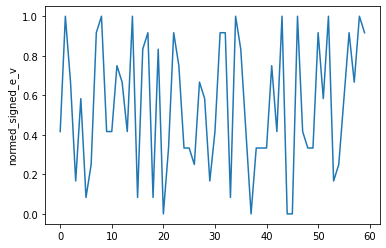

In [23]:
sns.lineplot(data=trials['normed_signed_e_v'])

### get response data

In [24]:
cred = credentials.Certificate('D:/Behavioural cybersecurity/project-notes/cards-dd-game-61b9b7f26a6e.json')
firebase_admin.initialize_app(cred)

db = firestore.client()

subjects_ref = db.collection(u'subjects')

Read game task responses from database

In [25]:
uuids = [
    '60cfbdfdfc788d1a1d9fae5a', 
    '60ce3a59841d20970e75ccbc', 
    '5b99065b57dc8100012c56a4', 
    '60c8cbb224ace51ce83667c1', 
    '60c6695104897f595c7d0319'
]

In [26]:
refs = []

for uuid in uuids:
    refs.append(subjects_ref.document(uuid).collection(u'responses').document('main_responses').get())

In [27]:
from scripts.data_processing import GameResponses

In [28]:
honesty_ratings = []

for index, subject in enumerate(refs):
    responses = GameResponses.from_dict(subject.to_dict())
    
    ratings = [int(numeric_string) for numeric_string in responses.honestyRating]
    honesty_ratings.append(ratings)

### normalize and reverse-code honesty ratings

In [29]:
import numexpr

In [30]:
normalized_honesty_ratings = []

for ratings in honesty_ratings:
    normed = [(v/6) for v in ratings]
    normalized_honesty_ratings.append(normed)

In [31]:
normalized_suspicion_ratings = numexpr.evaluate('(1 - normalized_honesty_ratings)')

Check if values are as expected

In [32]:
list(zip(honesty_ratings[0], normalized_honesty_ratings[0], normalized_suspicion_ratings[0]))

[(5, 0.8333333333333334, 0.16666666666666663),
 (1, 0.16666666666666666, 0.8333333333333334),
 (5, 0.8333333333333334, 0.16666666666666663),
 (5, 0.8333333333333334, 0.16666666666666663),
 (5, 0.8333333333333334, 0.16666666666666663),
 (5, 0.8333333333333334, 0.16666666666666663),
 (6, 1.0, 0.0),
 (1, 0.16666666666666666, 0.8333333333333334),
 (1, 0.16666666666666666, 0.8333333333333334),
 (0, 0.0, 1.0),
 (6, 1.0, 0.0),
 (5, 0.8333333333333334, 0.16666666666666663),
 (5, 0.8333333333333334, 0.16666666666666663),
 (5, 0.8333333333333334, 0.16666666666666663),
 (0, 0.0, 1.0),
 (5, 0.8333333333333334, 0.16666666666666663),
 (5, 0.8333333333333334, 0.16666666666666663),
 (5, 0.8333333333333334, 0.16666666666666663),
 (5, 0.8333333333333334, 0.16666666666666663),
 (5, 0.8333333333333334, 0.16666666666666663),
 (6, 1.0, 0.0),
 (5, 0.8333333333333334, 0.16666666666666663),
 (5, 0.8333333333333334, 0.16666666666666663),
 (5, 0.8333333333333334, 0.16666666666666663),
 (5, 0.8333333333333334, 0.

### define parameter space

In [33]:
alpha = np.linspace(0, 1, 101)
prior = np.linspace(0, 1, 101)

params = (list(product(alpha, prior)))

In [34]:
def fit_single_model(responses, params, trials, stat: str):
    best_params = []
    best_r2 = []
    for i, r in enumerate(responses):
        print('response subject', i)
        ss_tot = np.sum((r-np.mean(r))**2)
        print('ss totals', ss_tot)
        r2 = []
        for param in params:
            pred = param[1] + param[0] * trials[stat]
            ss_res = np.sum((r-pred)**2)
            r2.append(1 - np.divide(ss_res, ss_tot))
        r2 = np.array(r2)
        best_idx = r2.argmax()
        print('best r2 index', best_idx)
        best_params.append(params[best_idx])
        best_r2.append(r2.max())
    return best_params, best_r2

In [35]:
def objective_single_model(params, response, trials, stat: str):
    ss_tot = np.sum((response-np.mean(response))**2)
    pred = params[0] + params[1] * trials[stat]
    return np.sum((response-pred)**2)

In [36]:
list(trials)

['n_red',
 'outcome',
 'trial',
 'n_blue',
 'e_v',
 'normed_signed_e_v',
 'normed_unsigned_e_v',
 'n_reported_colour_opp',
 'n_consec_colour',
 'signed_n_consec_colour',
 'normed_signed_colour_count',
 'normed_unsigned_colour_count',
 'cs_signed_e_v',
 'normed_cs_signed_e_v',
 'cs_unsigned_e_v',
 'normed_cs_unsigned_e_v']

### model 1.1: signed suspicion with update rule

Grid search approach

In [37]:
fit_single_model(normalized_suspicion_ratings, params, trials, 'normed_cs_signed_e_v')

response subject 0
ss totals 4.298148148148149
best r2 index 2945
response subject 1
ss totals 0.8569444444444447
best r2 index 3042
response subject 2
ss totals 2.1828703703703702
best r2 index 2146
response subject 3
ss totals 3.9833333333333343
best r2 index 3852
response subject 4
ss totals 1.0273148148148148
best r2 index 16


([(0.29, 0.16), (0.3, 0.12), (0.21, 0.25), (0.38, 0.14), (0.0, 0.16)],
 [0.03937751328450401,
  0.21492706645056736,
  0.04282916224814404,
  0.0752993181465984,
  -0.0008832807570977597])

skopt Bayesian optimization approach

In [38]:
param_search_space = [Real(0, 1, name='prior'), Real(0, 1, name='alpha')]

In [39]:
for i, response in enumerate(normalized_suspicion_ratings):
    ss_tot =  np.sum((response-np.mean(response))**2)
    gp_result = gp_minimize(partial(objective_single_model, response=response, trials=trials, stat='normed_cs_signed_e_v'), param_search_space, random_state=42)
    optimal_ss_res = gp_result.fun
    print("Subject", i)
    print("Best parameter estimates: prior =", (gp_result.x[0], "alpha =", gp_result.x[1]))
    print("R2:", 1 - np.divide(optimal_ss_res, ss_tot))
    pred = gp_result.x[0] + gp_result.x[1] * trials['normed_cs_signed_e_v']
    mse = mean_squared_error(response, pred)
    print("mean squared error", mse)
    print("SD error", np.std(response-pred))
    bic = calculate_bic(len(response), mse, len(param_search_space))
    aic = calculate_aic(len(response), mse, len(param_search_space))
    print("BIC:", bic)
    print("AIC:", aic)
    print("=" * 100)

Subject 0
Best parameter estimates: prior = (0.16006129172487255, 'alpha =', 0.28931789976223155)
R2: 0.03937417512552399
mean squared error 0.06881520183745862
SD error 0.26232589043568305
BIC: -152.39114696618117
AIC: -156.57983609062538
Subject 1
Best parameter estimates: prior = (0.11962466061654517, 'alpha =', 0.29977838323353534)
R2: 0.2149362884517031
mean squared error 0.011212599769104152
SD error 0.10588954635504676
BIC: -261.25434009227064
AIC: -265.4430292167148
Subject 2
Best parameter estimates: prior = (0.249602411019274, 'alpha =', 0.21144396324639628)
R2: 0.04284145080960122
mean squared error 0.034822550612906865
SD error 0.1866079330477783
BIC: -193.2607166324959
AIC: -197.4494057569401
Subject 3
Best parameter estimates: prior = (0.13726165535899668, 'alpha =', 0.38752877329729557)
R2: 0.07532876047025372
mean squared error 0.0613878961798915
SD error 0.24776574877679075
BIC: -159.24386650850548
AIC: -163.4325556329497
Subject 4
Best parameter estimates: prior = (0.

In [1]:
m1_mse = [0.06881520183745862, 0.011212599769104152, 0.034822550612906865, 0.0613878961798915, 0.017121922815502136]

<AxesSubplot:ylabel='Density'>

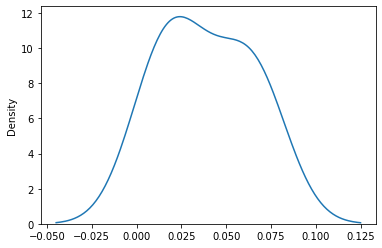

In [3]:
sns.kdeplot(data=m1_mse)

### model 1.2: signed suspicion, no update

Using grid search approach

In [40]:
fit_single_model(normalized_suspicion_ratings, params, trials, 'normed_signed_e_v')

response subject 0
ss totals 4.298148148148149
best r2 index 4148
response subject 1
ss totals 0.8569444444444447
best r2 index 2738
response subject 2
ss totals 2.1828703703703702
best r2 index 4555
response subject 3
ss totals 3.9833333333333343
best r2 index 4954
response subject 4
ss totals 1.0273148148148148
best r2 index 820


([(0.41000000000000003, 0.07),
  (0.27, 0.11),
  (0.45, 0.1),
  (0.49, 0.05),
  (0.08, 0.12)],
 [0.25875344679017676,
  0.5684683954619125,
  0.5912778366914103,
  0.39943410041841,
  0.03467868409193331])

skopt Bayesian optimization approach

In [41]:
param_search_space = [Real(0, 1, name='prior'), Real(0, 1, name='alpha')]

In [42]:
for i, response in enumerate(normalized_suspicion_ratings):
    ss_tot =  np.sum((response-np.mean(response))**2)
    gp_result = gp_minimize(partial(objective_single_model, response=response, trials=trials, stat='normed_signed_e_v'), param_search_space, random_state=42)
    optimal_ss_res = gp_result.fun
    print("Subject", i)
    print("Best parameter estimates: prior =", (gp_result.x[0], "alpha =", gp_result.x[1]))
    print("R2:", 1 - np.divide(optimal_ss_res, ss_tot))
    pred = gp_result.x[0] + gp_result.x[1] * trials['normed_signed_e_v']
    print("mean squared error", mse)
    print("SD error", np.std(response-pred))
    mse = mean_squared_error(response, pred)
    bic = calculate_bic(len(response), mse, len(param_search_space))
    aic = calculate_aic(len(response), mse, len(param_search_space))
    print("BIC:", bic)
    print("AIC:", aic)
    print("=" * 100)

Subject 0
Best parameter estimates: prior = (0.06753386345261717, 'alpha =', 0.41686880140251087)
R2: 0.2588305084417666
mean squared error 0.017121922815502136
SD error 0.23042193615076753
BIC: -167.95248538359715
AIC: -172.14117450804136
Subject 1
Best parameter estimates: prior = (0.10826296503309171, 'alpha =', 0.2756364084953586)
R2: 0.5688177172816393
mean squared error 0.05309427129341544
SD error 0.07847497069699277
BIC: -297.20837680798394
AIC: -301.3970659324281
Subject 2
Best parameter estimates: prior = (0.10337871191203363, 'alpha =', 0.4480197883962651)
R2: 0.5914214376519733
mean squared error 0.006158321028639551
SD error 0.12192030656433273
BIC: -244.3378067905375
AIC: -248.52649591498172
Subject 3
Best parameter estimates: prior = (0.045396767597091534, 'alpha =', 0.49719631210219245)
R2: 0.39952604026796446
mean squared error 0.014864567295300508
SD error 0.19966088592672201
BIC: -185.14700538903966
AIC: -189.33569451348387
Subject 4
Best parameter estimates: prior =

In [4]:
m2_mse = [0.017121922815502136, 0.05309427129341544, 0.006158321028639551, 0.014864567295300508, 0.03986479899332126]

<AxesSubplot:ylabel='Density'>

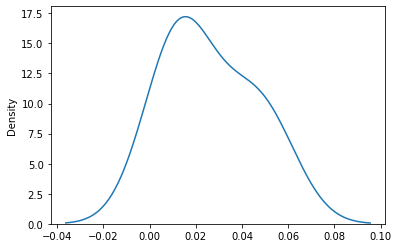

In [5]:
sns.kdeplot(data=m2_mse)

### model 1.3: unsigned suspicion with update rule

In [43]:
fit_single_model(normalized_suspicion_ratings, params, trials, 'normed_cs_unsigned_e_v')

response subject 0
ss totals 4.298148148148149
best r2 index 733
response subject 1
ss totals 0.8569444444444447
best r2 index 629
response subject 2
ss totals 2.1828703703703702
best r2 index 35
response subject 3
ss totals 3.9833333333333343
best r2 index 32
response subject 4
ss totals 1.0273148148148148
best r2 index 16


([(0.07, 0.26),
  (0.06, 0.23),
  (0.0, 0.35000000000000003),
  (0.0, 0.32),
  (0.0, 0.16)],
 [0.004754703571138386,
  0.022370394871656818,
  -0.00021208907741265826,
  -0.00016736401673633772,
  -0.0008832807570977597])

skopt Bayesian optimization approach

In [44]:
param_search_space = [Real(0, 1, name='prior'), Real(0, 1, name='alpha')]

In [45]:
for i, response in enumerate(normalized_suspicion_ratings):
    ss_tot =  np.sum((response-np.mean(response))**2)
    gp_result = gp_minimize(partial(objective_single_model, response=response, trials=trials, stat='normed_cs_unsigned_e_v'), param_search_space, random_state=42)
    optimal_ss_res = gp_result.fun
    print("Subject", i)
    print("Best parameter estimates: prior =", (gp_result.x[0], "alpha =", gp_result.x[1]))
    print("R2:", 1 - np.divide(optimal_ss_res, ss_tot))
    pred = gp_result.x[0] + gp_result.x[1] * trials['normed_cs_unsigned_e_v']
    mse = mean_squared_error(response, pred)
    print("mean squared error", mse)
    print("SD error", np.std(response-pred))
    bic = calculate_bic(len(response), mse, len(param_search_space))
    aic = calculate_aic(len(response), mse, len(param_search_space))
    print("BIC:", bic)
    print("AIC:", aic)
    print("=" * 100)

Subject 0
Best parameter estimates: prior = (0.2625350858288658, 'alpha =', 0.06386205224104001)
R2: 0.0047930607357122845
mean squared error 0.07129244771704976
SD error 0.26700645498475145
BIC: -150.2692036632022
AIC: -154.45789278764641
Subject 1
Best parameter estimates: prior = (0.22736442634875706, 'alpha =', 0.06050098744996384)
R2: 0.022543734105424984
mean squared error 0.013960428612429467
SD error 0.11815210255616726
BIC: -248.10301962894428
AIC: -252.2917087533885
Subject 2
Best parameter estimates: prior = (0.34707700985306833, 'alpha =', 0.0)
R2: -5.796028692550692e-07
mean squared error 0.03638119392613834
SD error 0.1907384933344766
BIC: -190.63350816935892
AIC: -194.82219729380313
Subject 3
Best parameter estimates: prior = (0.31665872924443744, 'alpha =', 0.0)
R2: -9.48994216543042e-10
mean squared error 0.06638888895189157
SD error 0.2576604138956718
BIC: -154.54484516937757
AIC: -158.73353429382178
Subject 4
Best parameter estimates: prior = (0.16405175309216682, 'a

In [6]:
m3_mse = [0.07129244771704976, 0.013960428612429467, 0.03638119392613834, 0.06638888895189157, 0.017121940104995622]

<AxesSubplot:ylabel='Density'>

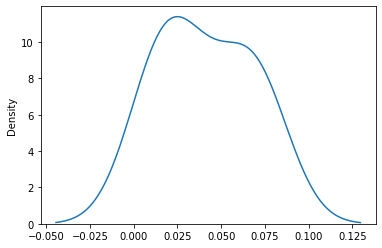

In [7]:
sns.kdeplot(data=m3_mse)

### model 1.4: unsigned suspicion, no update

In [46]:
fit_single_model(normalized_suspicion_ratings, params, trials, 'normed_unsigned_e_v')

response subject 0
ss totals 4.298148148148149
best r2 index 3843
response subject 1
ss totals 0.8569444444444447
best r2 index 2033
response subject 2
ss totals 2.1828703703703702
best r2 index 2644
response subject 3
ss totals 3.9833333333333343
best r2 index 2641
response subject 4
ss totals 1.0273148148148148
best r2 index 1522


([(0.38, 0.05), (0.2, 0.13), (0.26, 0.18), (0.26, 0.15), (0.15, 0.07)],
 [0.13593479235727035,
  0.17511593292098038,
  0.1215722639426926,
  0.07749705405174634,
  0.08439948128868491])

skopt Bayesian optimization approach

In [47]:
param_search_space = [Real(0, 1, name='prior'), Real(0, 1, name='alpha')]

In [48]:
for i, response in enumerate(normalized_suspicion_ratings):
    ss_tot =  np.sum((response-np.mean(response))**2)
    gp_result = gp_minimize(partial(objective_single_model, response=response, trials=trials, stat='normed_unsigned_e_v'), param_search_space, random_state=42)
    optimal_ss_res = gp_result.fun
    print("Subject", i)
    print("Best parameter estimates: prior =", (gp_result.x[0], "alpha =", gp_result.x[1]))
    print("R2:", 1 - np.divide(optimal_ss_res, ss_tot))
    pred = gp_result.x[0] + gp_result.x[1] * trials['normed_unsigned_e_v']
    mse = mean_squared_error(response, pred)
    print("mean squared error", mse)
    print("SD error", np.std(response-pred))
    bic = calculate_bic(len(response), mse, len(param_search_space))
    aic = calculate_aic(len(response), mse, len(param_search_space))
    print("BIC:", bic)
    print("AIC:", aic)
    print("=" * 100)

Subject 0
Best parameter estimates: prior = (0.055563528734661624, 'alpha =', 0.3719666853588678)
R2: 0.13599754375470519
mean squared error 0.0618935092884361
SD error 0.248783945294344
BIC: -158.75170864425223
AIC: -162.94039776869644
Subject 1
Best parameter estimates: prior = (0.1366540252751193, 'alpha =', 0.1891780947971276)
R2: 0.175736392894993
mean squared error 0.011772468647772904
SD error 0.10850098822743058
BIC: -258.3308092170594
AIC: -262.5194983415036
Subject 2
Best parameter estimates: prior = (0.18671485751027644, 'alpha =', 0.25026520386834394)
R2: 0.12173157730664075
mean squared error 0.031952435285487565
SD error 0.17875204291918104
BIC: -198.42172363327532
AIC: -202.61041275771953
Subject 3
Best parameter estimates: prior = (0.1432466383763459, 'alpha =', 0.2701863782332308)
R2: 0.07761686049167793
mean squared error 0.061235991761802507
SD error 0.24745892225640687
BIC: -159.3925205742105
AIC: -163.5812096986547
Subject 4
Best parameter estimates: prior = (0.071

In [8]:
m4_mse = [0.0618935092884361, 0.011772468647772904, 0.031952435285487565, 0.061235991761802507, 0.015668579941343873]

<AxesSubplot:ylabel='Density'>

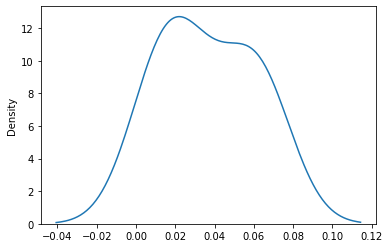

In [9]:
sns.kdeplot(data=m4_mse)

### model 2.1: signed colours tracker

In [49]:
fit_single_model(normalized_suspicion_ratings, params, trials, 'normed_signed_colour_count')

response subject 0
ss totals 4.298148148148149
best r2 index 5155
response subject 1
ss totals 0.8569444444444447
best r2 index 4247
response subject 2
ss totals 2.1828703703703702
best r2 index 6266
response subject 3
ss totals 3.9833333333333343
best r2 index 6767
response subject 4
ss totals 1.0273148148148148
best r2 index 1323


([(0.51, 0.04), (0.42, 0.05), (0.62, 0.04), (0.67, 0.0), (0.13, 0.1)],
 [0.14165088323998276,
  0.48910210696920586,
  0.4200571792152702,
  0.41417782426778227,
  0.03293465525011241])

skopt Bayesian optimization approach

In [50]:
param_search_space = [Real(0, 1, name='prior'), Real(0, 1, name='alpha')]

In [51]:
for i, response in enumerate(normalized_suspicion_ratings):
    ss_tot =  np.sum((response-np.mean(response))**2)
    gp_result = gp_minimize(partial(objective_single_model, response=response, trials=trials, stat='normed_signed_colour_count'), param_search_space, random_state=42)
    optimal_ss_res = gp_result.fun
    print("Subject", i)
    print("Best parameter estimates: prior =", (gp_result.x[0], "alpha =", gp_result.x[1]))
    print("R2:", 1 - np.divide(optimal_ss_res, ss_tot))
    pred = gp_result.x[0] + gp_result.x[1] * trials['normed_signed_colour_count']
    mse = mean_squared_error(response, pred)
    print("mean squared error", mse)
    print("SD error", np.std(response-pred))
    bic = calculate_bic(len(response), mse, len(param_search_space))
    aic = calculate_aic(len(response), mse, len(param_search_space))
    print("BIC:", bic)
    print("AIC:", aic)
    print("=" * 100)

Subject 0
Best parameter estimates: prior = (0.03915466288069492, 'alpha =', 0.512464276885494)
R2: 0.14164602300505458
mean squared error 0.06148887594460706
SD error 0.24796949037449856
BIC: -159.14525084433862
AIC: -163.33393996878283
Subject 1
Best parameter estimates: prior = (0.048610897508172254, 'alpha =', 0.42033070695785024)
R2: 0.4891668850841957
mean squared error 0.007295926664422485
SD error 0.08541580819373859
BIC: -287.0376555398241
AIC: -291.22634466426825
Subject 2
Best parameter estimates: prior = (0.03643898945808369, 'alpha =', 0.6244120305233275)
R2: 0.42016096466534236
mean squared error 0.021095224163602707
SD error 0.14524144782539733
BIC: -223.33382730016183
AIC: -227.52251642460604
Subject 3
Best parameter estimates: prior = (0.0, 'alpha =', 0.6668199929267258)
R2: 0.41422583961608783
mean squared error 0.03888889564770973
SD error 0.19658213900566493
BIC: -186.6341025577555
AIC: -190.82279168219972
Subject 4
Best parameter estimates: prior = (0.1041048218289

In [10]:
m5_mse = [0.06148887594460706, 0.007295926664422485, 0.021095224163602707, 0.03888889564770973, 0.016553651832327546]

<AxesSubplot:ylabel='Density'>

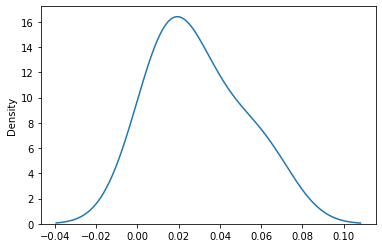

In [11]:
sns.kdeplot(data=m5_mse)

### model 2.2: unsigned colours tracker

In [52]:
fit_single_model(normalized_suspicion_ratings, params, trials, 'normed_unsigned_colour_count')

response subject 0
ss totals 4.298148148148149
best r2 index 29
response subject 1
ss totals 0.8569444444444447
best r2 index 831
response subject 2
ss totals 2.1828703703703702
best r2 index 35
response subject 3
ss totals 3.9833333333333343
best r2 index 32
response subject 4
ss totals 1.0273148148148148
best r2 index 16


([(0.0, 0.29),
  (0.08, 0.23),
  (0.0, 0.35000000000000003),
  (0.0, 0.32),
  (0.0, 0.16)],
 [-0.00027574321413181835,
  0.022086223662884596,
  -0.00021208907741265826,
  -0.00016736401673633772,
  -0.0008832807570977597])

skopt Bayesian optimization approach

In [53]:
param_search_space = [Real(0, 1, name='prior'), Real(0, 1, name='alpha')]

In [54]:
for i, response in enumerate(normalized_suspicion_ratings):
    ss_tot =  np.sum((response-np.mean(response))**2)
    gp_result = gp_minimize(partial(objective_single_model, response=response, trials=trials, stat='normed_unsigned_colour_count'), param_search_space, random_state=42)
    optimal_ss_res = gp_result.fun
    print("Subject", i)
    print("Best parameter estimates: prior =", (gp_result.x[0], "alpha =", gp_result.x[1]))
    print("R2:", 1 - np.divide(optimal_ss_res, ss_tot))
    pred = gp_result.x[0] + gp_result.x[1] * trials['normed_unsigned_colour_count']
    mse = mean_squared_error(response, pred)
    print("mean squared error", mse)
    print("SD error", np.std(response-pred))
    bic = calculate_bic(len(response), mse, len(param_search_space))
    aic = calculate_aic(len(response), mse, len(param_search_space))
    print("BIC:", bic)
    print("AIC:", aic)
    print("=" * 100)

Subject 0
Best parameter estimates: prior = (0.2942735104508001, 'alpha =', 0.0)
R2: -4.0787468247316383e-07
mean squared error 0.071635831687566
SD error 0.2676486548987979
BIC: -149.98090413343883
AIC: -154.16959325788304
Subject 1
Best parameter estimates: prior = (0.22767658068337407, 'alpha =', 0.08963216716005812)
R2: 0.022458679922409464
mean squared error 0.013961643390923
SD error 0.11815934034908832
BIC: -248.09779890537837
AIC: -252.28648802982258
Subject 2
Best parameter estimates: prior = (0.3469522371817191, 'alpha =', 0.0)
R2: -2.00356163415627e-06
mean squared error 0.03638124573142828
SD error 0.1907384933344766
BIC: -190.63342273194337
AIC: -194.82211185638758
Subject 3
Best parameter estimates: prior = (0.31674129710472015, 'alpha =', 0.0)
R2: -8.389509709161302e-08
mean squared error 0.06638889445859118
SD error 0.2576604138956718
BIC: -154.5448401926116
AIC: -158.7335293170558
Subject 4
Best parameter estimates: prior = (0.16409562468991526, 'alpha =', 0.0)
R2: -2.

In [12]:
m6_mse = [0.071635831687566, 0.013961643390923, 0.03638124573142828, 0.06638889445859118, 0.017121956319938337]

<AxesSubplot:ylabel='Density'>

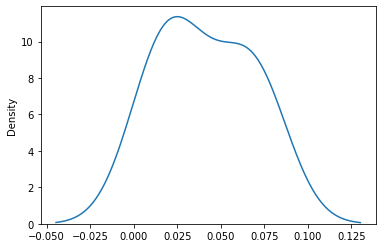

In [13]:
sns.kdeplot(data=m6_mse)

### weighted combined models

### model 3.1: combined signed suspicion + colours tracker, one alpha as weight

In [55]:
alpha = np.linspace(0, 1, 101)
prior = np.linspace(0, 1, 101)

params = (list(product(alpha, prior)))

In [56]:
def fit_combi_model_a(responses, prior, alpha, trials):
    best_params = []
    best_r2 = []
    params = list(product(prior, alpha))
    for i, r in enumerate(responses):
        print('response subject', i)
        ss_tot = np.sum((r-np.mean(r))**2)
        print('ss totals', ss_tot)
        r2 = []
        for param in params:
            pred = param[0] + param[1] * trials['normed_signed_e_v'] + (1-param[1]) * trials['normed_signed_colour_count']
            ss_res = np.sum((r-pred)**2)
            r2.append(1 - np.divide(ss_res, ss_tot))
        r2 = np.array(r2)
        best_idx = r2.argmax()
        print('best r2 index', best_idx)
        best_params.append(params[best_idx])
        best_r2.append(r2.max())
    return best_params, best_r2

In [57]:
fit_combi_model_a(normalized_suspicion_ratings, prior, alpha, trials)

response subject 0
ss totals 4.298148148148149
best r2 index 11
response subject 1
ss totals 0.8569444444444447
best r2 index 0
response subject 2
ss totals 2.1828703703703702
best r2 index 13
response subject 3
ss totals 3.9833333333333343
best r2 index 2
response subject 4
ss totals 1.0273148148148148
best r2 index 0


([(0.0, 0.11), (0.0, 0.0), (0.0, 0.13), (0.0, 0.02), (0.0, 0.0)],
 [-0.5623245799224474,
  -4.45867098865478,
  -0.3341812513255571,
  -0.06649623430962315,
  -8.26904010815683])

### model 3.2: combined signed suspicion + colours tracker, additional weight

In [58]:
prior = np.linspace(0, 1, 101)
alpha1 = np.linspace(0, 1, 101)
alpha2 = np.linspace(0, 1, 101)
weight = np.linspace(0, 1, 11)

In [59]:
# def fit_combi_model_b(responses, prior, alpha1, alpha2, weight, trials):
#     best_params = []
#     best_r2 = []
#     params = list(product(prior, alpha1, alpha2, weight))
#     print(len(params))
#     for i, r in enumerate(responses):
#         print('response subject', i)
#         ss_tot = np.sum((r-np.mean(r))**2)
#         print('ss totals', ss_tot)
#         r2 = []
#         for param in params:
#             pred = param[0] + param[3] * param[1] * trials['normed_signed_e_v'] + (1-param[3]) * param[2] * trials['normed_signed_colour_count']
#             ss_res = np.sum((r-pred)**2)
#             r2.append(1 - np.divide(ss_res, ss_tot))
#         r2 = np.array(r2)
#         best_idx = r2.argmax()
#         print('best r2 index', best_idx)
#         best_params.append(params[best_idx])
#         best_r2.append(r2.max())
#     return best_params, best_r2

In [ ]:
# fit_combi_model_b(normalized_suspicion_ratings, prior, alpha1, alpha2, weight, trials)

Gaussian Process minimization with skopt

In [61]:
param_search_space = [Real(0, 1, name='prior'), Real(0, 1, name='alpha1'), Real(0, 1, name='alpha2'), Real(0, 1, name='weight')]

In [62]:
def objective_weighted(params, response, trials):
    pred = params[0] + params[3] * params[1] * trials['normed_signed_e_v'] + (1-params[3]) * params[2] * trials['normed_signed_colour_count']
    ss_res = np.sum((response-pred)**2)
    return ss_res

In [63]:
# gp_result = gp_minimize(partial(objective, response=normalized_suspicion_ratings[0], trials=trials), param_search_space, random_state=42)

In [64]:
for i, response in enumerate(normalized_suspicion_ratings):
    ss_tot =  np.sum((response-np.mean(response))**2)
    gp_result = gp_minimize(partial(objective_weighted, response=response, trials=trials), param_search_space, random_state=42)
    optimal_ss_res = gp_result.fun
    print("Subject", i)
    print("Best parameter estimates: prior =", (gp_result.x[0], "alpha 1 =", gp_result.x[1], "alpha 2 =", gp_result.x[2], "weight =", gp_result.x[3]))
    print("R2:", 1 - np.divide(optimal_ss_res, ss_tot))
    pred = gp_result.x[0] + gp_result.x[3] * gp_result.x[1] * trials['normed_signed_e_v'] + (1 - gp_result.x[3]) * gp_result.x[2] * trials['normed_signed_colour_count']
    mse = mean_squared_error(response, pred)
    print("mean squared error", mse)
    print("SD error", np.std(response-pred))
    bic = calculate_bic(len(response), mse, len(param_search_space))
    aic = calculate_aic(len(response), mse, len(param_search_space))
    print("BIC:", bic)
    print("AIC:", aic)
    print("=" * 100)

Subject 0
Best parameter estimates: prior = (0.07069439598318544, 'alpha 1 =', 0.43155625329125763, 'alpha 2 =', 0.19539825446739917, 'weight =', 0.9341413950730619)
R2: 0.2584928832251515
mean squared error 0.05311845734674148
SD error 0.23046441560999817
BIC: -159.73647065998563
AIC: -168.11384890887402
Subject 1
Best parameter estimates: prior = (0.08372902837461246, 'alpha 1 =', 0.42814962223966907, 'alpha 2 =', 0.30738638827817544, 'weight =', 0.34374275822151285)
R2: 0.5949914933838569
mean squared error 0.005784496494957416
SD error 0.07581490950055016
BIC: -292.7770592570625
AIC: -301.1544375059509
Subject 2
Best parameter estimates: prior = (0.06832710928581165, 'alpha 1 =', 0.7352543484096302, 'alpha 2 =', 0.3049827769030515, 'weight =', 0.5120682038260442)
R2: 0.601757805304751
mean squared error 0.014488518117192125
SD error 0.12036800944666003
BIC: -237.68654958457145
AIC: -246.06392783345984
Subject 3
Best parameter estimates: prior = (0.0, 'alpha 1 =', 0.9133338920477662

## combined model without added weight parameter

In [65]:
def objective_weighted_b(params, response, trials):
    pred = params[0] + params[1] * trials['normed_signed_e_v'] + params[2] * trials['normed_signed_colour_count']
    ss_res = np.sum((response-pred)**2)
    return ss_res

In [66]:
param_search_space = [Real(0, 1, name='prior'), Real(0, 1, name='alpha1'), Real(0, 1, name='alpha2')]

In [67]:
for i, response in enumerate(normalized_suspicion_ratings):
    ss_tot =  np.sum((response-np.mean(response))**2)
    gp_result = gp_minimize(partial(objective_weighted_b, response=response, trials=trials), param_search_space, random_state=42)
    optimal_ss_res = gp_result.fun
    print("Subject", i)
    print("Best parameter estimates: prior =", (gp_result.x[0], "alpha 1 =", gp_result.x[1], "alpha 2 =", gp_result.x[2]))
    print("R2:", 1 - np.divide(optimal_ss_res, ss_tot))
    pred = gp_result.x[0] + gp_result.x[1] * trials['normed_signed_e_v'] + gp_result.x[2] * trials['normed_signed_colour_count']
    mse = mean_squared_error(response, pred)
    print("mean squared error", mse)
    print("SD error", np.std(response-pred))
    bic = calculate_bic(len(response), mse, len(param_search_space))
    aic = calculate_aic(len(response), mse, len(param_search_space))
    print("BIC:", bic)
    print("AIC:", aic)
    print("=" * 100)

Subject 0
Best parameter estimates: prior = (0.06705001394483227, 'alpha 1 =', 0.41430505919094857, 'alpha 2 =', 0.0)
R2: 0.2587793813866489
mean squared error 0.053097933821036676
SD error 0.23042263557199122
BIC: -163.85400206830698
AIC: -170.13703575497328
Subject 1
Best parameter estimates: prior = (0.06425753644099105, 'alpha 1 =', 0.18728744844299602, 'alpha 2 =', 0.1861086438125473)
R2: 0.6076259021956362
mean squared error 0.005604046720955847
SD error 0.07485747980328511
BIC: -298.7729451214948
AIC: -305.0559788081611
Subject 2
Best parameter estimates: prior = (0.0631961516807351, 'alpha 1 =', 0.37440724944232867, 'alpha 2 =', 0.16274778899471118)
R2: 0.6017034851843623
mean squared error 0.01449049434688064
SD error 0.12037294954189681
BIC: -241.77271072221055
AIC: -248.05574440887685
Subject 3
Best parameter estimates: prior = (0.0, 'alpha 1 =', 0.2611881714151274, 'alpha 2 =', 0.37656785786542796)
R2: 0.4620614442652058
mean squared error 0.03571314300572662
SD error 0.188

In [14]:
m7_mse = [0.053097933821036676, 0.005604046720955847, 0.01449049434688064, 0.03571314300572662, 0.016460770525484877]

<AxesSubplot:ylabel='Density'>

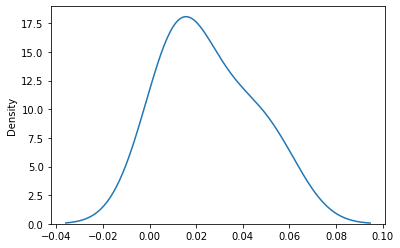

In [15]:
sns.kdeplot(data=m7_mse)